In [27]:
import pandas as pd
import scipy.stats
import numpy as np
import pylab 
import scipy.stats as stats
from matplotlib import pyplot as plt
plt.style.use('seaborn')
# %matplotlib notebook
import seaborn as sns
import random
random.seed(1)


# 1 VaR and Expected Shortfall

#### Definition 1.1     
Let $\alpha \in (0, 1)$ be a fixed level. The Value-at-Risk (VaR) for level $\alpha \in (0, 1)$ is defined as

$$VaR_\alpha(L_{n+1}) = \inf \{ \mathcal{l} \in \mathbb{R} : P(L_{n+1} > \mathcal{l}) \leq 1-\alpha \} $$


#### Definition 1.2     
Suppose that the conditional law of $\{ L_{n+1}$ given $Z_0, . . . , Z_n$ is continuous.
For fixed level $\alpha \in (0, 1)$ the expected shortfall at level $\alpha$ is defined as

$$ES_\alpha(L_{n+1}) = \mathbb{E}_n \{ L_{n+1} |  L_{n+1}>VaR_\alpha(L_{n+1}) \} $$

Let's study these risk measures with simulated log-normal returns and fat-tailed but stationary GARCH returns. 

## 1.1 GARCH

In [28]:
def generate_garch_11_ts(n, sigma_sq_0, mu, alpha, beta, omega):
    """ generate GARCH log returns """
    nu = np.random.normal(0,1,n)
    r = np.zeros(n)
    epsilon = np.zeros(n)
    sigma_sq = np.zeros(n)
    sigma_sq[0] = sigma_sq_0
    
    if min(alpha,beta)<0:
        raise ValueError('alpha, beta need to be non-negative')
    if omega <=0:
        raise ValueError('omega needs to be positive')
        
    if alpha+beta>=1:
        print('alpha+beta>=1, variance not defined --> time series will not be weakly stationary')
        
    for i in range(n):
        
        if i >0:
            sigma_sq[i] = omega + alpha * epsilon[i-1]**2 + beta * sigma_sq[i-1]
            
        epsilon[i] = (sigma_sq[i]**0.5) * nu[i]

        r[i] = mu + epsilon[i]
    return r 
    


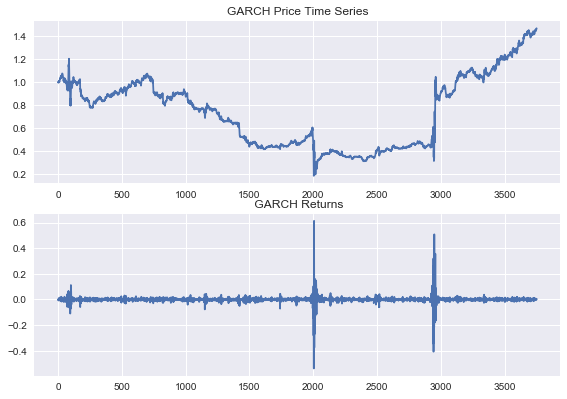

In [29]:
garch_returns = generate_garch_11_ts(250*15, 1e-5, 0.0, 0.5, 0.45, 1e-5)
price = np.exp(np.cumsum(garch_returns))


fig, axes = plt.subplots(2,1)
fig.tight_layout()
for ax, y, name in zip(axes, [price,garch_returns], ['GARCH Price Time Series',' GARCH Returns']):
    ax.plot(y)
    ax.set(title=name)
plt.show()

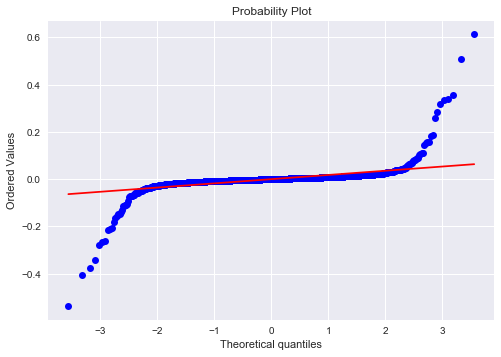

In [30]:
stats.probplot(garch_returns, dist="norm", plot=pylab)
pylab.show()

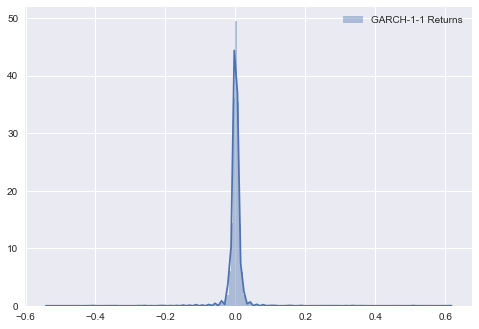

In [31]:
sns.distplot(garch_returns, bins=200, label='GARCH-1-1 Returns')
plt.legend()
plt.show()

The QQ-Plot very clearly shows fat tails. For the histogram, however, one could falsely assume normality.

In [32]:
def VaR_log_normal(x, alpha, lookback):
    """ compute daily VaR given log-normal returns """
    quantile = scipy.stats.norm.ppf(alpha)

    x = pd.Series(x)
    returns = (np.log(x)).diff()
    mu = returns.rolling(lookback).mean()
    sigma = returns.rolling(lookback).std()
    VaR = x*(1-np.exp((mu-sigma*quantile)))
    return VaR

alpha = 0.99
lookback = 250
VaR = VaR_log_normal(price, alpha, lookback)


In [33]:
loss = -pd.Series(np.diff(price))

violation = (loss.values[lookback:]>VaR.values[lookback:-1]).astype(int)
violation


array([0, 0, 0, ..., 0, 0, 0])

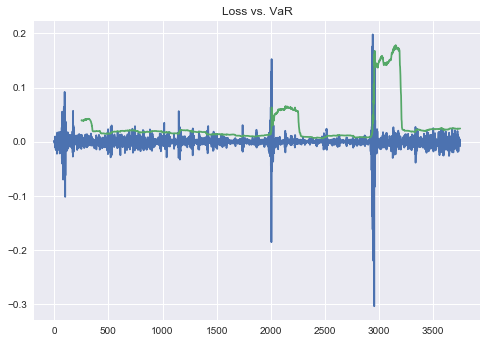

In [34]:
plt.plot(loss)
plt.plot(VaR)
plt.title('Loss vs. VaR')
plt.show()


In [35]:
print(f'Relative Frequency of Violations ({round(1-alpha,4)} expected under log-normal assumption): ', violation.mean())

Relative Frequency of Violations (0.01 expected under log-normal assumption):  0.023721063160903114


## 1.2 Log-Normal

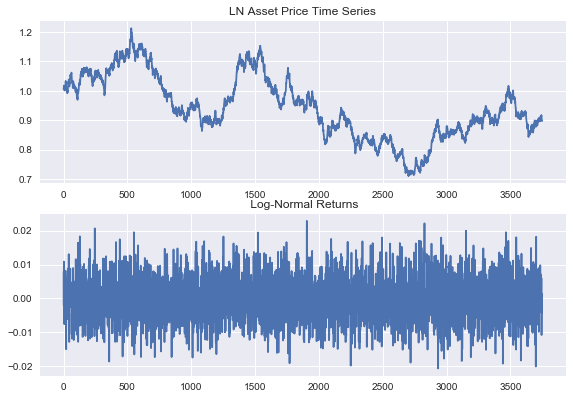

In [36]:
log_normal_returns =  np.random.normal(0,0.1/(250**0.5),len(garch_returns))
ln_price =  np.exp(np.cumsum(log_normal_returns))
fig, axes = plt.subplots(2,1)
fig.tight_layout()

for ax, y, name in zip(axes, [ln_price,log_normal_returns], ['LN Asset Price Time Series',' Log-Normal Returns']):
    ax.plot(y)
    ax.set(title=name)
plt.show()


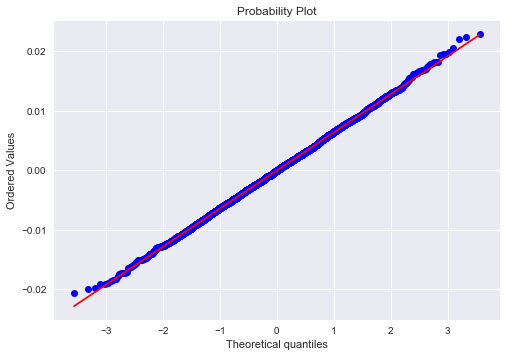

In [37]:
stats.probplot((log_normal_returns), dist="norm", plot=pylab)
pylab.show()


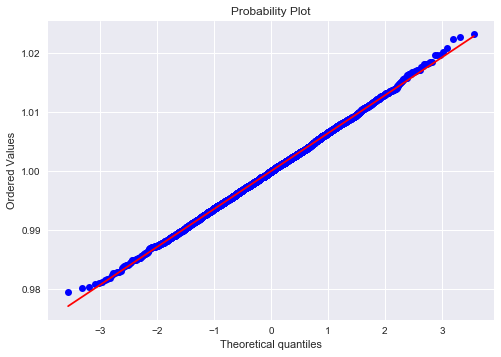

In [38]:
stats.probplot(np.exp(log_normal_returns), dist="norm", plot=pylab)
pylab.show()

For comparison, below are platykurtic and leptokurtic distributions:

#### Platykurtic (negative excess kurtosis)

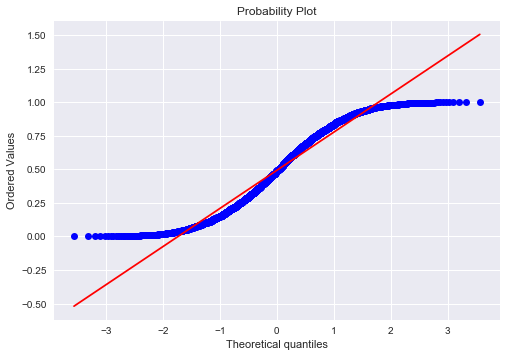

In [39]:
stats.probplot(np.random.uniform(0,1,log_normal_returns.shape), dist="norm", plot=pylab)
pylab.show()



#### Leptokurtic (positive excess kurtosis)

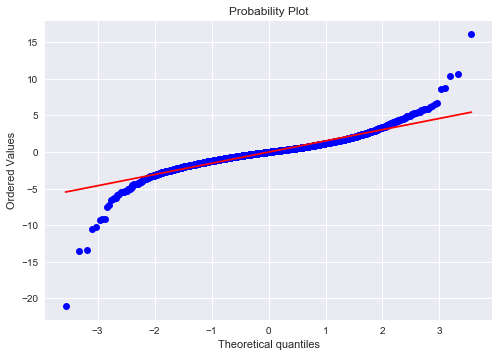

In [40]:
stats.probplot(np.random.standard_t(3,log_normal_returns.shape), dist="norm", plot=pylab)
pylab.show()

In [41]:
ln_VaR = VaR_log_normal(ln_price, alpha, lookback)
ln_loss = -pd.Series(np.diff(ln_price))

ln_violation = (ln_loss.values[lookback:]>ln_VaR.values[lookback:-1]).astype(int)


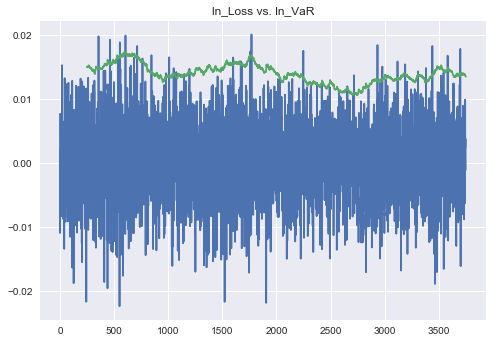

In [42]:
plt.plot(ln_loss)
plt.plot(ln_VaR)
plt.title('ln_Loss vs. ln_VaR')
plt.show()

In [43]:
print(f'Relative Frequency of Violations ({round(1-alpha,4)} expected under log-normal assumption): ', ln_violation.mean())

Relative Frequency of Violations (0.01 expected under log-normal assumption):  0.009145470134324093


As can be seen from the above experiments the log-normal VaR estimate severely under estimates the risk if the return distribution is fat tailed.

In [44]:
def phi(x):
    return np.exp(-0.5*x**2)/np.sqrt(2*np.pi);


def VaR_ES_var_covar (x, c, w, alpha):
    mu = np.mean(x,axis=0);
    sigma = np.cov(x);
    q = scipy.stats.norm.ppf(alpha)
    
    VaR = -(c + np.dot(np.transpose(w),np.transpose(mu))) + np.sqrt(np.dot(np.transpose(w),np.dot(sigma,w)))*q
    ES = -(c + np.dot(np.transpose(w),np.transpose(mu))) + np.sqrt(np.dot(np.transpose(w),np.dot(sigma,w)))/(1-alpha)*phi(q)
    return VaR, ES

VaR, ES = VaR_ES_var_covar (garch_returns, 0, 1, alpha)

print('VaR GARCH: ', VaR)
print('Expected Shortfall GARCH: ', ES)
print('Mean Violation GARCH: ',np.mean(-garch_returns[garch_returns<-VaR]))

VaR GARCH:  0.06865213941382685
Expected Shortfall GARCH:  0.07866716860717192
Mean Violation GARCH:  0.1845558352008992


In [45]:
VaR, ES = VaR_ES_var_covar (log_normal_returns, 0, 1, alpha)

print('VaR Log-Normal: ', VaR)
print('Expected Shortfall Log-Normal: ', ES)
print('Mean Violation Log-Normal: ',np.mean(-log_normal_returns[log_normal_returns<-VaR]))

VaR Log-Normal:  0.014949296205778208
Expected Shortfall Log-Normal:  0.017122700994277786
Mean Violation Log-Normal:  0.0168420001558527


The Var-Covar method assumes iid Gaussian risk factor changes. It thus under-estimates ES of the GARCH model. 
The ES estimate of the log-normal returns is unbiased. 

In [46]:
def VaR_ES_historic(x, alpha):
    x = np.sort(x)
    index = int(len(x)*(1-alpha))+1
    VaR = x[index]
    ES = 1/index*np.sum(x[:index])
    return -VaR,-ES


In [47]:
hist_VaR,hist_ES = VaR_ES_historic(garch_returns, alpha)
print('VaR GARCH: ', hist_VaR)
print('Expected Shortfall GARCH: ', hist_ES)


VaR GARCH:  0.0514445301255086
Expected Shortfall GARCH:  0.15183930753712083


### Some remarks regarding VaR and ES



### Coherent risk measures
A coherent risk measure is a function ${\displaystyle \varrho }  $ that satisfies properties of monotonicity, sub-additivity, homogeneity, and translational invariance.

#### Monotonicity

${\displaystyle \mathrm {If} \;Z_{1},Z_{2}\in {\mathcal {L}}\;\mathrm {and} \;Z_{1}\leq Z_{2}\;\mathrm {a.s.} ,\;\mathrm {then} \;\varrho (Z_{1})\geq \varrho (Z_{2})} $
That is, if portfolio ${\displaystyle Z_{2}}  $ always has better values than portfolio ${\displaystyle Z_{1}}$ under almost all scenarios then the risk of ${\displaystyle Z_{2}} $ should be less than the risk of ${\displaystyle Z_{1}}$.

#### Sub-additivity

${\displaystyle \mathrm {If} \;Z_{1},Z_{2}\in {\mathcal {L}},\;\mathrm {then} \;\varrho (Z_{1}+Z_{2})\leq \varrho (Z_{1})+\varrho (Z_{2})} $
Indeed, the risk of two portfolios together cannot get any worse than adding the two risks separately: this is the diversification principle. In financial risk management, sub-additivity implies diversification is beneficial.

#### Positive homogeneity


${\displaystyle \mathrm {If} \;\alpha \geq 0\;\mathrm {and} \;Z\in {\mathcal {L}},\;\mathrm {then} \;\varrho (\alpha Z)=\alpha \varrho (Z)} $
Loosely speaking, if you double your portfolio then you double your risk. In financial risk management, positive homogeneity implies the risk of a position is proportional to its size.

#### Translation invariance
If ${\displaystyle A}$  is a deterministic portfolio with guaranteed return ${\displaystyle a}$  and ${\displaystyle Z\in {\mathcal {L}}}  $ then

$ {\displaystyle \varrho (Z+A)=\varrho (Z)-a} \varrho(Z + A) = \varrho(Z) - a $
The portfolio ${\displaystyle A}$ is just adding cash ${\displaystyle a} $ to your portfolio ${\displaystyle Z}$. In particular, if ${\displaystyle a=\varrho (Z)}$  then ${\displaystyle \varrho (Z+A)=0}$. In financial risk management, translation invariance implies that the addition of a sure amount of capital reduces the risk by the same amount.

### Convex risk measures

The notion of coherence has been subsequently relaxed. Indeed, the notions of Sub-additivity and Positive Homogeneity can be replaced by the notion of convexity:

#### Convexity
${\displaystyle {\text{If }}Z_{1},Z_{2}\in {\mathcal {L}}{\text{ and }}\lambda \in [0,1]{\text{ then }}\varrho (\lambda Z_{1}+(1-\lambda )Z_{2})\leq \lambda \varrho (Z_{1})+(1-\lambda )\varrho (Z_{2})}$



VaR is not a convex risk measure, meaning diversification with non-perfectly-correlated assets does not always lead to reduction in the risk measure, which is a serious flaw. In addition, VaR only provides information about the probability of a large loss but not its amount. ES does not suffer from these drawbacks.


# 2 Extreme Value Theory

#### Definition 2.1
A function $h : (0,+\infty) → (0,+\infty)$ with the limit

$$ g(t)=\lim _{{t\to \infty }}{\frac  {h(tx)}{h(x)}} = x^\rho $$

for every $x > 0$, is called regularly varying in $\infty$ with
index $\rho \in \mathbb{R}$ (written $h \in RV_\rho$)

For $\rho = 0$, and hence $g(t)=1$ we say that $h$ is slowly varying in $\infty$.


A random variable $X$ with cdf $F$ is called regularly varying if $\bar F \in RV_{-\alpha}$ for some $\alpha \geq 0$, where $\bar F(x) = 1 − F(x)$.


To estimate the parameter $\alpha$ of a regularly varying random variable $X$, we use the Hill estimator.

#### Hill's tail-index estimator

$$\displaystyle \hat\alpha _{(k(n),n)}^{\text{Hill}}=\left({\frac {1}{k(n)}}\sum _{i=n-k(n)+1}^{n}\ln(X_{(i,n)})-\ln(X_{(n-k(n)+1,n)})\right)^{-1}$$

Choose k graphically by looking at the Hill plot. If we are lucky, the plot looks approximately constant after some initial oscillations. This is the part where k and hence the estimate should be chosen.

In [48]:
def Hill_Estimator (x, k):
    y = np.sort(x)[::-1]
    return k / np.sum( np.log(y[:k-2]) - np.log(y[k-1]) )


def Hill_Plot(x):
    y=x[x>0]
    n = len(y)
    a = []
    for k in range(1,n):
        
        alpha_hat = Hill_Estimator(y,k)
        a.append(alpha_hat)
    
    plt.plot(range(1,n), a)  
    plt.show()
    
    
def VaR_ES_Hill(x, p, k):
    n = len(x)
    alpha = Hill_Estimator(x,k)
    y = np.sort(x)[::-1]
    VaR= (n/k*(1-p))**(-1/alpha)*y[k]
    ES=(1-1/alpha)**(-1)*VaR
    return VaR,ES


/Users/jan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


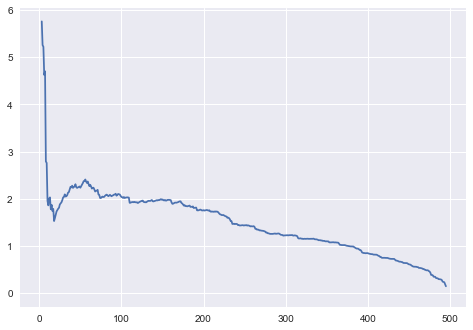

In [49]:
# n=1000
x = garch_returns[:1000]#np.random.standard_t(10, n)**2
Hill_Plot(x)


In [50]:
k = 50

VaR, ES = VaR_ES_Hill(x,0.95,k)

alpha = Hill_Estimator(x,k)
print('Alpha_HILL: ', alpha)

print('VaR HILL: ', VaR)
print('ES HILL: ', ES)


Alpha_HILL:  2.234537476607904
VaR HILL:  0.01578942948307785
ES HILL:  0.028579182554375387


### Peaks Over Treshold (POT)

Let $X$ be a random variable with cdf $F$ . Define its excess distribution function over threshold $u$ as

$$\displaystyle F_{u}(y)=P(X-u\leq y|X>u)={\frac {F(u+y)-F(u)}{1-F(u)}}$$

for $0\leq y\leq x_{F}-u$ . 

In [51]:
def mean_exess_fct(x, u):
    
    if u>=max(x):
        raise ValueError(" u must be smaller than max(x) ") 
        
    e = np.mean(x[x>u]-u)
    return e


def mean_exess_plot(x):
    
    x = pd.Series(x)
    x = x.sort_values(ascending=False)
    e = x[1:].apply(lambda u:  mean_exess_fct(x, u))
    
    plt.plot(x[1:],e,'.')
    plt.xlabel(r'$u$')
    plt.ylabel(r'$e(u)$')
    plt.title('Mean Exess Plot')
    plt.show()


log-normal returns


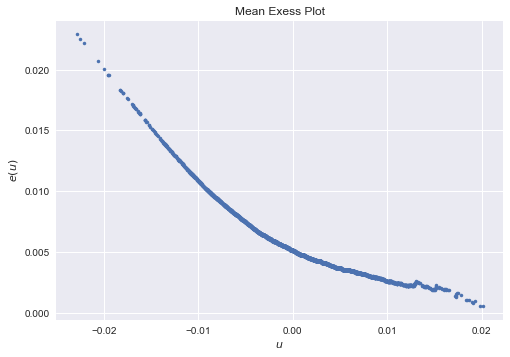

GARCH returns


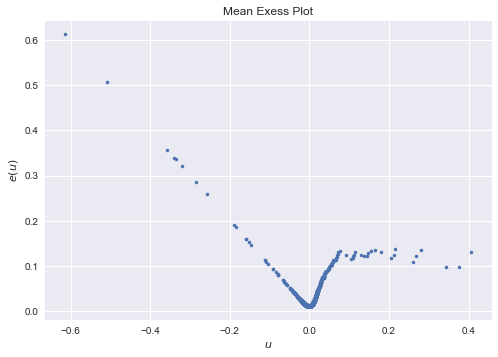

In [52]:
print('log-normal returns')
mean_exess_plot(-log_normal_returns)

print('GARCH returns')
mean_exess_plot(-garch_returns)


If the mean exess plot behaves approximately linear with positive slope for some u, it is reasonable to assume that the tails are generalized pareto distributed and u should be chosen where this is the case. Here, for the GARCH returns, this would be around 0.025. Since this rule is nowhere true for log-normal returns, it is not reasonable to assume tails to have generalized pareto distribution.

In [53]:
def ml_estimator_pareto(u, x):
    y = x[x>u]-u
    N_u = len(y)
    
    def log_likelihood(x):
       #negative log likelihood of generalized pareto distribution
        return N_u*np.log(x[1])+(1/x[0]+1)*np.sum(np.log(1+x[0]/x[1]*y))
    
    
    #first guess
    x0=[1,2]
    
    #bounds
    bnds = [(0.000001,5),(0.000001,5)]
    
    res = scipy.optimize.minimize(log_likelihood, x0, bounds=bnds)
    
    if not res.success:
        raise ValueError('optimization unsuccessful')

    gamma = res.x[0]
    beta = res.x[1]
    return gamma, beta, N_u


In [54]:
def var_pot(p,gamma, beta, N_u, n, u):
    return  u + beta/gamma *( (n/N_u*(1-p))**(-gamma) - 1 )
   

def es_pot(q, beta, gamma, u):
    return q + (beta + gamma*(q - u))/(1-gamma)


================= ML ESTIMATION RESULTS ===============
 Gamma: 0.9069354804944628
 Beta: 0.016802893009081294



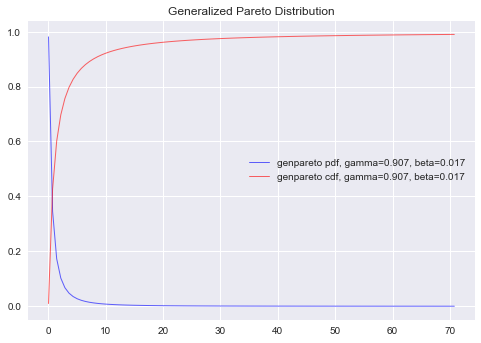

In [55]:
from scipy.stats import genpareto

u = 0.025
n = len(garch_returns)
gamma, beta, N_u = ml_estimator_pareto(u, -garch_returns)
p = 0.99

print(f'================= ML ESTIMATION RESULTS ===============\n Gamma: {gamma}\n Beta: {beta}\n')

fig, ax = plt.subplots(1, 1)
x = np.linspace(genpareto.ppf(0.01, gamma, beta),
              genpareto.ppf(0.99, gamma,beta), 100)
ax.plot(x, genpareto.pdf(x, gamma,beta),
         'b-', lw=1, alpha=0.6, label=f'genpareto pdf, gamma={round(gamma,3)}, beta={round(beta,3)}')
ax.plot(x, genpareto.cdf(x, gamma,beta),
         'r-', lw=1, alpha=0.6, label=f'genpareto cdf, gamma={round(gamma,3)}, beta={round(beta,3)}')
ax.set(title = 'Generalized Pareto Distribution')
ax.legend()
plt.show()


In [56]:
VaR = var_pot(p,gamma, beta, N_u, n, u)
ES = es_pot(VaR, beta, gamma, u)
print(f'================= POT ESTIMATES ===============\n VaR: {VaR}\n ES: {ES}\n')


================= POT ESTIMATES ===============
 VaR: 0.0519772528712982
 ES: 0.49542789360530304



## Copulas

To model dependence we use copulas. In essence, these are multivariate distribution functions that transform the margins to be uniformly distributed with support [0,1].

By Sklar’s theorem, any multivariate joint distribution can be written in terms of univariate marginal distribution functions and a copula which describes the dependence structure between the two variables.

For example, a Gaussian copula $ C_{R}^{\text{Gauss}}(u)=\Phi _{R}\left(\Phi ^{-1}(u_{1}),\dots ,\Phi ^{-1}(u_{d})\right) $ is a multivariate Gaussian distribution function that transforms the marginals into uniform [0,1]. Its density is ${\displaystyle c_{R}^{\text{Gauss}}(u)={\frac {1}{\sqrt {\det {R}}}}\exp \left(-{\frac {1}{2}}{\begin{pmatrix}\Phi ^{-1}(u_{1})\\\vdots \\\Phi ^{-1}(u_{d})\end{pmatrix}}^{T}\cdot \left(R^{-1}-I\right)\cdot {\begin{pmatrix}\Phi ^{-1}(u_{1})\\\vdots \\\Phi ^{-1}(u_{d})\end{pmatrix}}\right)}$. To use them we model multivariate Gaussian rvs with positive-definite covariance matrix. We then transform the marginal realizations to standard uniform rvs by applying the CDF. After that, we transform the uniform marginals into the desired distribution function by applying the inverse CDF. 

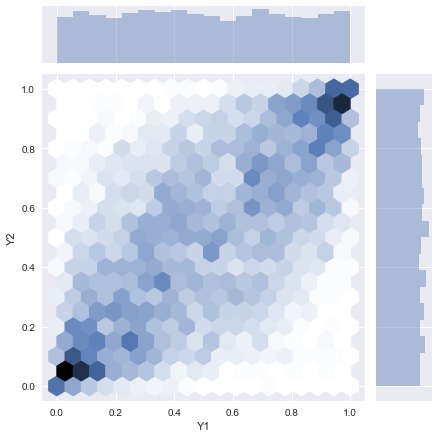

In [57]:
multi_variate_gauss = stats.multivariate_normal(mean=[0, 0], cov=[[1., 0.7], 
                                                     [0.7, 1.]])
x = multi_variate_gauss.rvs(5000)

x_uniform = stats.norm().cdf(x)
h = sns.jointplot(x_uniform[:, 0], x_uniform[:, 1], kind='hex', stat_func=None)
h.set_axis_labels('Y1', 'Y2');

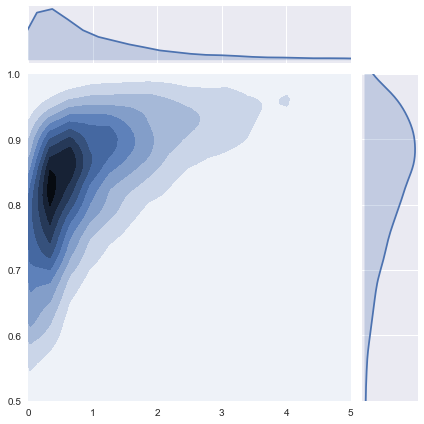

In [58]:
x1_transform = stats.genpareto(c=0.25).ppf(x_uniform[:, 0])
x2_transform = stats.beta(a=10, b=2).ppf(x_uniform[:, 1])

sns.jointplot(x1_transform, x2_transform, kind='kde', xlim=(0, 5), ylim=(.5, 1.0), stat_func=None);


Compare this to the jointplot of independent rvs.

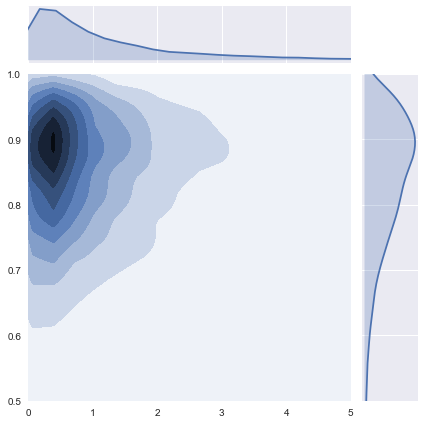

In [59]:
x1_transform = stats.genpareto(c=0.25).ppf(stats.uniform().rvs(5000))
x2_transform = stats.beta(a=10, b=2).ppf(stats.uniform().rvs(5000))

sns.jointplot(x1_transform, x2_transform, kind='kde', xlim=(0, 5), ylim=(.5, 1.0), stat_func=None);




## Tail Dependence


The lower tail dependence is defined as
$${\displaystyle \lambda _{\ell }=\lim _{q\rightarrow 0}\operatorname {P} (X_{2}\leq F_{2}^{\leftarrow }(q)\mid X_{1}\leq F_{1}^{\leftarrow }(q)).}$$ where ${\displaystyle F^{\leftarrow }(q)=\inf\{x\in \mathbb {R} :F(x)\geq q\}} {\displaystyle F^{\leftarrow }(q)=\inf\{x\in \mathbb {R} :F(x)\geq q\}}$, that is, the inverse of the cumulative probability distribution function for $q$.

The upper tail dependence is defined analogously as

$${\displaystyle \lambda _{u}=\lim _{q\rightarrow 1}\operatorname {P} (X_{2}>F_{2}^{\leftarrow }(q)\mid X_{1}>F_{1}^{\leftarrow }(q)).}$$

Gaussian copulas are easy to understand but lack the flexibility to model tail dependence and radial asymmetry, which is very important for risk management. For that we need to consider the class of Archimedean copulas ${\displaystyle C(u_{1},\dots ,u_{d};\theta )=\psi ^{[-1]}\left(\psi (u_{1};\theta )+\cdots +\psi (u_{d};\theta );\theta \right)}$ like the Gumbel copula or the Clayton Copula.

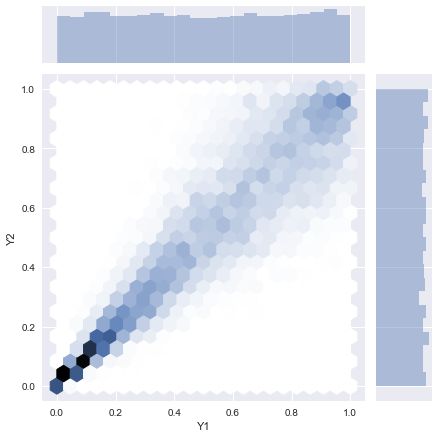

In [60]:
from numpy.random import gamma


def clayton_copula(n, delta, d=2):
    x = gamma(1/delta,1, size=n)
    v = stats.uniform().rvs([n,d])
    u = (1-np.log(v)/x[:,None])**(-1/delta)
    return u


n = 10000
delta = 6
u = clayton_copula(n, delta)
h = sns.jointplot(u[:,0], u[:,1], kind='hex', stat_func=None)
h.set_axis_labels('Y1', 'Y2');

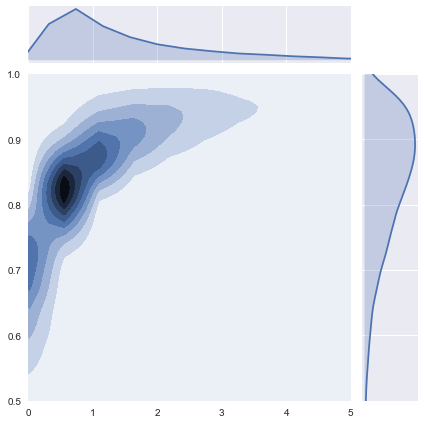

In [62]:
x1_transform = stats.genpareto(c=0.25).ppf(u[:,0])
x2_transform = stats.beta(a=10, b=2).ppf(u[:,1])

sns.jointplot(x1_transform, x2_transform, kind='kde', xlim=(0, 5), ylim=(.5, 1.0), stat_func=None);

In [63]:
x = stats.uniform().rvs([n,3])

In [64]:
kt = scipy.stats.kendalltau(x1_transform,x2_transform)
print("Kendall's Tau: ", kt)

Kendall's Tau:  KendalltauResult(correlation=0.7504475247524752, pvalue=0.0)


In [65]:
sr = scipy.stats.spearmanr(x1_transform,x2_transform)
print("Spearman's Rho: ", sr)

Spearman's Rho:  SpearmanrResult(correlation=0.9104663427086636, pvalue=0.0)


In [66]:
pc = scipy.stats.pearsonr(x1_transform,x2_transform)
print('Pearson Corr: ', pc)

Pearson Corr:  (0.5253282431534392, 0.0)


In [67]:
lamda_l = 2**(-1/delta)
print('Tail Dependence Coefficient: ',lamda_l)

Tail Dependence Coefficient:  0.8908987181403393
